In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import cv2
import time



from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features # VGG 모델에 대한 매개변수에서 받아 온 features값을 self.features에 넣어줍니다. 
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

## VGG 모델 유형 정의

In [3]:
vgg11_config = [64, 'M', 129, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] # 8 Conv, 3 Pooling

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'] # 10 Conv, 3 Pooling

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'] # 13 Conv, 3 Pooling

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'] # 16Conv, 3 Pooling

## VGG 계층 정의

In [4]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3
    
    for c in config:
        assert c == 'M' or isinstance(c, int) #assert문: 주어진 조건이 True가 아니면 에러를 발생. 
        if c == 'M': # 불러온 값이 'M'이면 MaxPooling 적용
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace =True)]
            in_channels = c
            
    return nn.Sequential(*layers) # 네트워크의 모든 계층을 반환
            
    
    

## 모델 계층 생성

In [5]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 129, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(129, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## VGG11 전체에 대한 네트워크

In [6]:
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 129, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(129, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(129, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

## 이미지 데이터 전처리 및 데이터셋 불러오기

In [7]:
train_transforms = transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.RandomRotation(10), # 10도 이하로 이미지를 회전시킵니다.
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.RandomVerticalFlip(0.8),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
])
test_transforms = transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.255])
])

In [8]:
train_path = '../input/cat-and-dog/training_set/training_set'
test_path = '../input/cat-and-dog/test_set/test_set'


train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform = train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform = test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

8005
2023


(None, None)

* ImageFolder는 계층적인 폴더 구조를 가지고 있는 데이터셋을 불러올 때 사용합니다.


## 훈련과 검증 데이터 분할
* 데이터가 DataLoader로 넘어간 이후에는 분리가 불가능하므로 dataset 단계에서 진행해야 합니다

In [9]:
VALID_RATIO = 0.9
n_train = int(len(train_dataset) * VALID_RATIO)
n_valid = len(train_dataset) - n_train

train_data, valid_data = data.random_split(train_dataset, [n_train, n_valid]) # 데이터

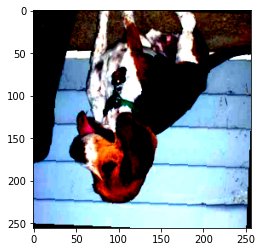

In [106]:
#plt.imshow(valid_data[0][0].permute(1, 2, 0)  )


## 검증 데이터 전처리
* 앞에서 훈련 데이터셋으로부터 분리된 valid_data를 valid_data라는 변수에 깊은 복사를 진행한 후 'test_transforms'로 전처리를 적용합니다

In [10]:
new_valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

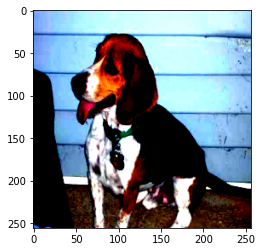

In [112]:
#plt.imshow(valid_data[0][0].permute(1, 2, 0)  )


In [11]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 7204
Number of validation examples: 801
Number of testing examples: 2023


## DataLoader를 이용하여 메모리로 데이터 불러오기

In [34]:
BATCH_SIZE = 8
train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset, 
                                batch_size = BATCH_SIZE)

In [35]:
optimizer = optim.Adam(model.parameters(), lr = 1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [36]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

## 모델 학습 함수 정의

In [37]:
def train(model, iterator, optimizer, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()    
    for (x, y) in iterator:        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()                
        y_pred, _ = model(x)        
        loss = criterion(y_pred, y)       
        acc = calculate_accuracy(y_pred, y)        
        loss.backward()        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## 모델 성능 측정 함수

In [38]:
def evaluate(model, iterator, criterion, device):    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()    
    with torch.no_grad():        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [39]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## 모델 학습

In [41]:
EPOCHS = 10
best_valid_loss = float('inf')
for epoch in range(EPOCHS):    
    start_time = time.monotonic()    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 2m 33s
	Train Loss: 0.664 | Train Acc: 60.43%
	 Valid. Loss: 0.640 |  Valid. Acc: 66.58%
Epoch: 02 | Epoch Time: 2m 33s
	Train Loss: 0.656 | Train Acc: 61.32%
	 Valid. Loss: 0.633 |  Valid. Acc: 66.46%
Epoch: 03 | Epoch Time: 2m 33s
	Train Loss: 0.647 | Train Acc: 63.30%
	 Valid. Loss: 0.622 |  Valid. Acc: 67.20%
Epoch: 04 | Epoch Time: 2m 33s
	Train Loss: 0.642 | Train Acc: 63.28%
	 Valid. Loss: 0.617 |  Valid. Acc: 67.57%
Epoch: 05 | Epoch Time: 2m 32s
	Train Loss: 0.637 | Train Acc: 63.28%
	 Valid. Loss: 0.609 |  Valid. Acc: 67.95%
Epoch: 06 | Epoch Time: 2m 33s
	Train Loss: 0.631 | Train Acc: 64.87%
	 Valid. Loss: 0.603 |  Valid. Acc: 69.43%
Epoch: 07 | Epoch Time: 2m 33s
	Train Loss: 0.622 | Train Acc: 64.97%
	 Valid. Loss: 0.598 |  Valid. Acc: 69.31%
Epoch: 08 | Epoch Time: 2m 32s
	Train Loss: 0.614 | Train Acc: 65.97%
	 Valid. Loss: 0.588 |  Valid. Acc: 70.42%
Epoch: 09 | Epoch Time: 2m 32s
	Train Loss: 0.610 | Train Acc: 66.66%
	 Valid. Loss: 0.582 |  Va

## 테스트 데이터셋을 이용한 모델 성능 측정

In [42]:
model.load_state_dict(torch.load('./VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.595 | Test Acc: 69.89%


In [43]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True) # 열을 따라 가장 큰 값의 색인을 찾는다. 
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

## 정확하게 예측한 이미지 추출

In [44]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [47]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max) # torch.clamp는 주어진 최소, 최대의 범주에 이미지가 위치하도록 한다.
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

In [48]:
def plot_most_correct(correct, classes, n_images, normalize = True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (25, 20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)        
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')
        
    fig.subplots_adjust(hspace = 0.4)

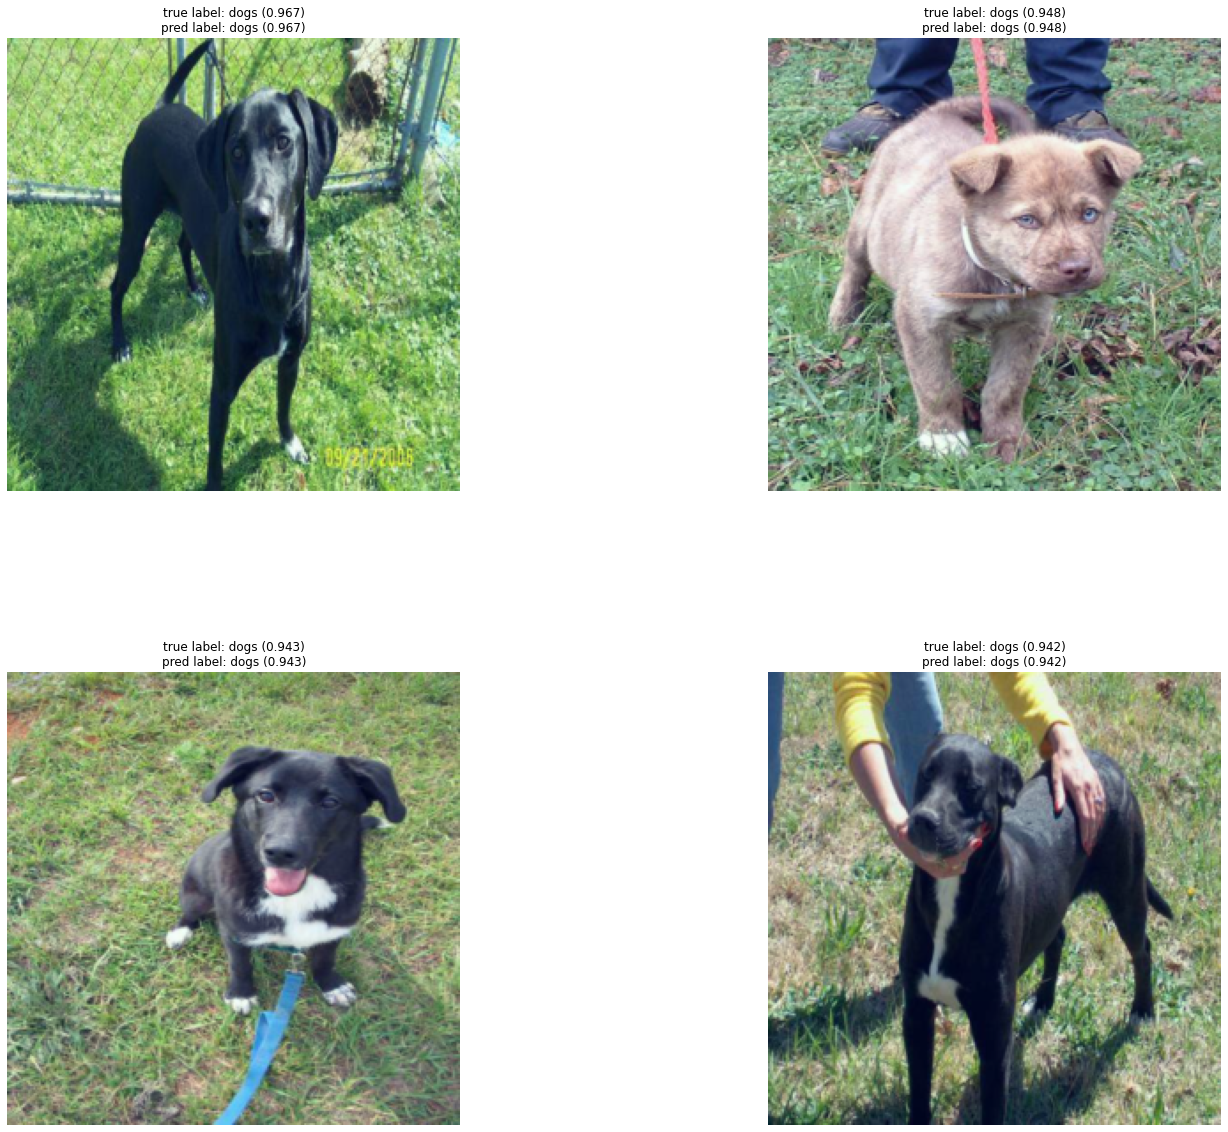

In [49]:
classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)

[](http://)